Os modelos que usei para a dissertação nao tem o ruído de saída como parâmetro (são fixos durante todo o treino e determinados por validação cruzada), com excessão do **Probabilistic Backprop** (**PBP**) cuja saída é média e variância preditivas e a variância estimada para o ruído aditivo de observação.

Uma abordagem mais interessante é estabelecer tal variável de ruído como parâmetro tunável interno do modelo. Como participa do cálculo da função objetivo, terá seu valor atualizado pelo otimizador. Nesse caso, haverá um parâmetro de ruído único para toda e qualquer entrada, logo o modelo será homocedástico. Note que esse representará o ruído dos dados (incerteza aleátoria) e não a do modelo (incerteza epistêmica), essa última é calculada fazendo-se MC nos pesos da rede e calculando a variância observada. Caso se deseje que o modelo seja capaz de predizer a incerteza heterocedástica, o parâmetro de variância deverá fazer parte da saída da rede. Os dois tipos de variância podem coexistir no modelo.

Para que sejam compatíveis com o **PBP**, certamente deve ser implementado nos outros modelos a capacidade de prever o ruído aditivo de saída (o parâmetro tunável atrelado ao modelo). E quanto a predição da variância pela rede, deve ser inclusa também ou apenas a oriunda da integração por amostragem de MC é suficiente?

Refletindo sobre o significado e origem desses dois termos, chega-se a conclusão que o MC é suficiente para os outros modelos e a rede não deve prever um termo de variância. Esse último corresponde a uma variânca que a rede preve para a *entrada* enquanto o PBP calcula sua variância analiticamente a partir da distribuição dos *pesos* e isso (variância oriunda dos pesos) é feito nos outros modelos por MC.

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [198]:
import torch
import theano
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bayesnn.datasets import Dataset

from bayesnn.uci_code.experiments_pbp import ExperimentPBPReg
from bayesnn.uci_code.experiments import ExperimentBBBMLPReg, ExperimentVadamMLPReg, ExperimentDropoutMLPReg

from bayesnn.utils import plot_1d_results

In [217]:
np.random.seed(0)

## Toy set #1

https://github.com/microsoft/deterministic-variational-inference/blob/master/ToyData.ipynb

In [759]:
def base_model(x):
    return -(x+0.5)*np.sin(3 * np.pi *x)

def noise_model(x):
    return 0.45*(x+0.5)**2

def sample_data(x):
    return base_model(x) + np.random.normal(0, noise_model(x))

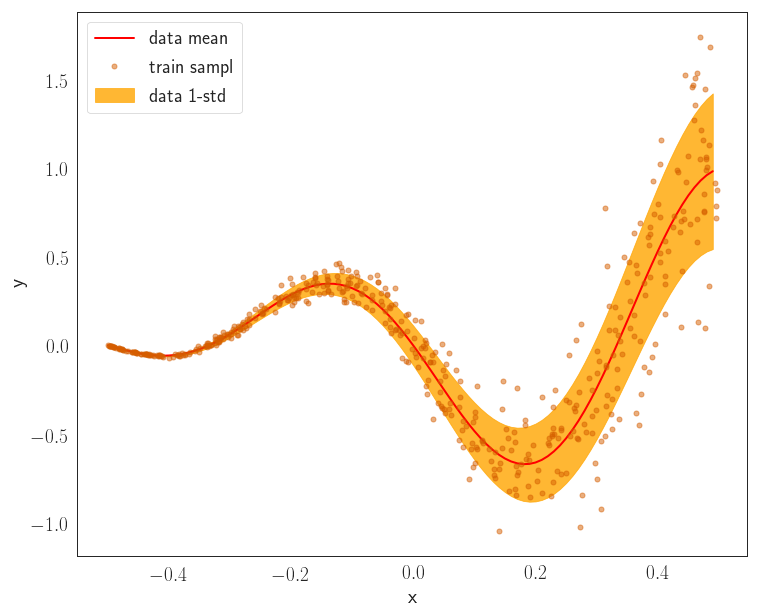

In [761]:
train_size, test_size = 500, 100

# X values: U[-0.5, 0.5]
train_data_1 = np.random.rand(train_size, 1) - 0.5
test_data_1 = np.random.rand(test_size, 1) - 0.5

# X domain for visualizing learned model
x_domain = torch.linspace(-1,1,100)[..., None]

data_1 = Dataset('toydata1d', x_points=(train_data_1, test_data_1), base=base_model, noise=noise_model)

plot_1d_results((data_1.train_set.train_data.numpy(), data_1.train_set.train_labels.numpy()),
                 {'mean':base_model, 'std':noise_model})

# filename = 'ex1_data_samples.pdf'
# fig.savefig( 'images/toy-example'+ filename, bbox_inches='tight', dpi=200)

In [764]:
model_params={'hidden_sizes': [50],
              'act_func': 'relu' ,
              'dropout': 0.3 ,
              'prior_prec': 1.0,
              'noise_prec': 25}

train_params={'batch_size': 500,
              'num_epochs': 20000, # 20000
              'seed': 123,
              'train_mc_samples': 20,
              'eval_mc_samples': 100}

optim_params={'learning_rate': 0.001,
              'betas': (0.9,0.99),
              'prec_init': 10.0}

dataset = 'toydata1d'
data_params={'x_points': (train_data_1, test_data_1),
             'base': base_model,
             'noise': noise_model}

In [765]:
BBB = ExperimentBBBMLPReg(dataset,
                            model_params,
                            train_params,
                            optim_params,
                            data_params=data_params,
                            evals_per_epoch=1,
                            normalize_x=True,
                            normalize_y=True,
                            use_cuda=torch.cuda.is_available(),
                            print_freq=2000
    )
BBB.run()

Epoch [1/20000], Neg. Ave. ELBO: 86.1930, Logloss: 10.8107, Test Logloss: 11.3833 Eval time: 0.000Batch time: 0.054 (0.054) Data time: 0.004 (0.004) 


KeyboardInterrupt: 

In [ ]:
x_mean, x_std = BBB.data.train_set.train_data.mean(dim=0), BBB.data.train_set.train_data.std(dim=0)
y_mean, y_std = BBB.data.train_set.train_labels.mean(dim=0), BBB.data.train_set.train_labels.std(dim=0)

In [ ]:
out = BBB.prediction((x_domain - x_mean)/x_std, train=False)
out = torch.stack(out).cpu().data.numpy()
out = out*y_std.numpy() + y_mean.numpy()

plot_1d_results((data.train_set.train_data.numpy(), data.train_set.train_labels.numpy()),
                 {'mean':base_model, 'std':noise_model}, (x_domain.numpy(), out, 1/model_params['noise_prec']),
                 method = 'bbb')

# filename = 'ex1_bbb.pdf'
# fig.savefig( 'images/toy-example'+ filename, bbox_inches='tight', dpi=200)

In [ ]:
Dropout = ExperimentDropoutMLPReg(dataset,
                                    model_params,
                                    train_params,
                                    optim_params,
                                    data_params=data_params,
                                    evals_per_epoch=1,
                                    normalize_x=True,
                                    normalize_y=True,
                                    use_cuda=torch.cuda.is_available(),
                                    print_freq=2000)

Dropout.run()

In [ ]:
out = Dropout.prediction((x_domain - x_mean)/x_std, train=False)
out = torch.stack(out).cpu().data.numpy()
out = out*y_std.numpy() + y_mean.numpy()

plot_1d_results((data_1.train_set.train_data.numpy(), data_1.train_set.train_labels.numpy()),
                 {'mean':base_model, 'std':noise_model}, (x_domain.numpy(), out, 1/model_params['noise_prec']),
                 method = 'mcdropout')

# filename = 'ex1_mcdropout.pdf'
# fig.savefig( 'images/toy-example'+ filename, bbox_inches='tight', dpi=200)

In [ ]:
Vadam = ExperimentVadamMLPReg(dataset,
                        model_params,
                        train_params,
                        optim_params,
                        data_params=data_params,
                        evals_per_epoch=1,
                        normalize_x=True,
                        normalize_y=True,
                        use_cuda=torch.cuda.is_available(),
                        print_freq=2000
    )
Vadam.run()

In [ ]:
out = Vadam.prediction((x_domain - x_mean)/x_std, train=False)
out = torch.stack(out).cpu().data.numpy()
out = out*y_std.numpy() + y_mean.numpy()

plot_1d_results((data_1.train_set.train_data.numpy(), data_1.train_set.train_labels.numpy()),
                 {'mean':base_model, 'std':noise_model}, (x_domain.numpy(), out, 1/model_params['noise_prec']),
                 method = 'vadam')

# filename = 'ex1_vadam.pdf'
# fig.savefig( 'images/toy-example'+ filename, bbox_inches='tight', dpi=200)

In [ ]:
train_params.update({'num_epochs': 40})

PBP = ExperimentPBPReg(dataset,
                        model_params,
                        train_params,
                        data_params,
                        experiment_prefix='toydata',
                        normalize_x=True,
                        normalize_y=True,
                        use_cuda=torch.cuda.is_available(),
                        print_freq=2000
    )
PBP.run()

In [ ]:
m, v, v_noise = PBP.model.predict(((x_domain - x_mean)/x_std).numpy())

plot_1d_results((data_1.train_set.train_data.numpy(), data_1.train_set.train_labels.numpy()),
                 {'mean':base_model, 'std':noise_model}, (x_domain.numpy(), (m, v), v_noise),
                 method = 'pbp')

# filename = 'ex1_pbp.pdf'
# fig.savefig( 'images/toy-example'+ filename, bbox_inches='tight', dpi=200)

## Toy set #2

https://github.com/ThirstyScholar/bayes-by-backprop/blob/master/BBB/bnn_regression.py  
https://arxiv.org/pdf/1502.05336.pdf

In [770]:
def base_model(x):
    return x**3

def noise_model(x):
    return 9*np.ones_like(x)

def sample_data(x):
    return base_model(x) + np.random.normal(0, noise_model(x))

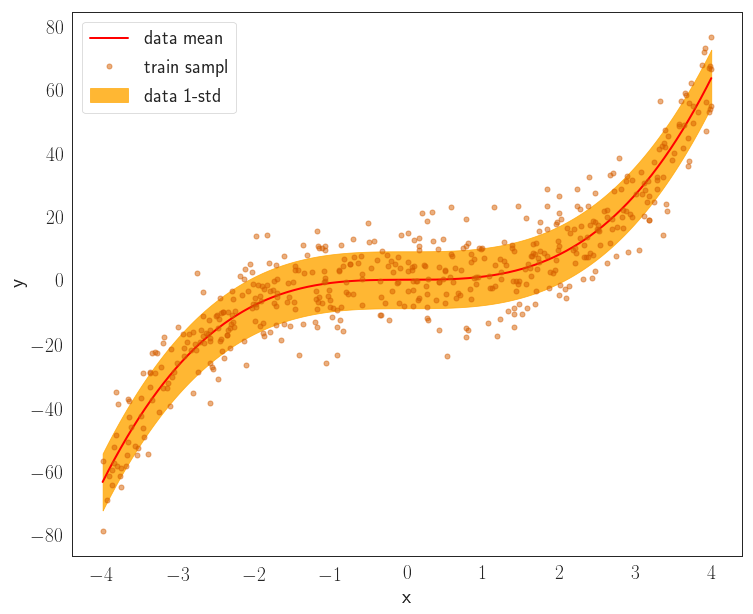

In [771]:
train_size, test_size = 500, 100

# X values: U[-4, 4]
train_data_2 = np.random.uniform(-4, 4, size=train_size).reshape((-1, 1))
test_data_2 = np.random.uniform(-4, 4, size=test_size).reshape((-1, 1))

# X domain for visualizing learned model
x_domain = torch.linspace(-6,6,100)[..., None]

data_2 = Dataset('toydata1d', x_points=(train_data_2, test_data_2), base=base_model, noise=noise_model)

plot_1d_results((data_2.train_set.train_data.numpy(), data_2.train_set.train_labels.numpy()),
                 {'mean':base_model, 'std':noise_model})
# plt.ylim([-60,60])

# filename = 'ex2_data_samples.pdf'
# fig.savefig( 'images/toy-example'+ filename, bbox_inches='tight', dpi=200)

In [772]:
model_params={'hidden_sizes': [100],
              'act_func': 'relu' ,
              'dropout': 0.3 ,
              'prior_prec': 1.0,
              'noise_prec': 1/9}

train_params={'batch_size': 500,
              'num_epochs': 1000, # 20000
              'seed': 123,
              'train_mc_samples': 10,
              'eval_mc_samples': 100}

optim_params={'learning_rate': 0.001,
              'betas': (0.9,0.99),
              'prec_init': 10.0}

dataset = 'toydata1d'
data_params={'x_points': (train_data, test_data),
             'base': base_model,
             'noise': noise_model}

In [773]:
BBB = ExperimentBBBMLPReg(dataset,
                            model_params,
                            train_params,
                            optim_params,
                            data_params=data_params,
                            evals_per_epoch=1,
                            normalize_x=True,
                            normalize_y=True,
                            use_cuda=torch.cuda.is_available(),
                            print_freq=1000
    )
BBB.run()

Epoch [1/1000], Neg. Ave. ELBO: 6.3794, Logloss: 5.3734, Test Logloss: 5.4057 Eval time: 0.000Batch time: 0.051 (0.051) Data time: 0.006 (0.006) 
toydata1d train time 100.002 (100.002)	


In [774]:
x_mean, x_std = BBB.data.train_set.train_data.mean(dim=0), BBB.data.train_set.train_data.std(dim=0)
y_mean, y_std = BBB.data.train_set.train_labels.mean(dim=0), BBB.data.train_set.train_labels.std(dim=0)

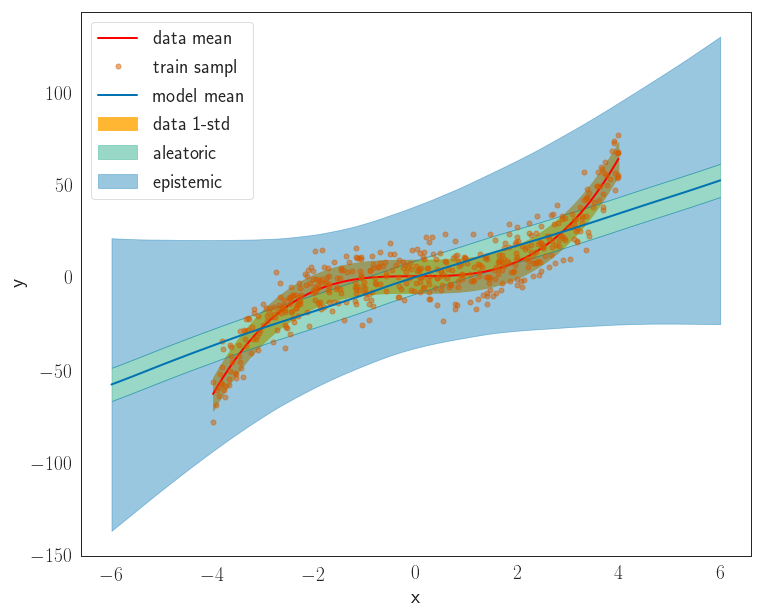

In [775]:
out = BBB.prediction((x_domain - x_mean)/x_std, train=False)
out = torch.stack(out).cpu().data.numpy()
out = out*y_std.numpy() + y_mean.numpy()

plot_1d_results((data_2.train_set.train_data.numpy(), data_2.train_set.train_labels.numpy()),
                 {'mean':base_model, 'std':noise_model},
                (x_domain.numpy(), out, 1/model_params['noise_prec']),
               method='bbb')
# plt.ylim([-60,60])

# filename = 'ex2_bbb.pdf'
# fig.savefig( 'images/toy-example'+ filename, bbox_inches='tight', dpi=200)

In [776]:
Dropout = ExperimentDropoutMLPReg(dataset,
                                    model_params,
                                    train_params,
                                    optim_params,
                                    data_params=data_params,
                                    evals_per_epoch=1,
                                    normalize_x=True,
                                    normalize_y=True,
                                    use_cuda=torch.cuda.is_available(),
                                    print_freq=2000)

Dropout.run()

Epoch [1/1000], Ave. MSE: 1126.8431, Logloss: 5.4420, Test Logloss: 5.4345 Eval time: 0.000Batch time: 0.060 (0.060) Data time: 0.007 (0.007) 
toydata1d train time 87.062 (87.062)	


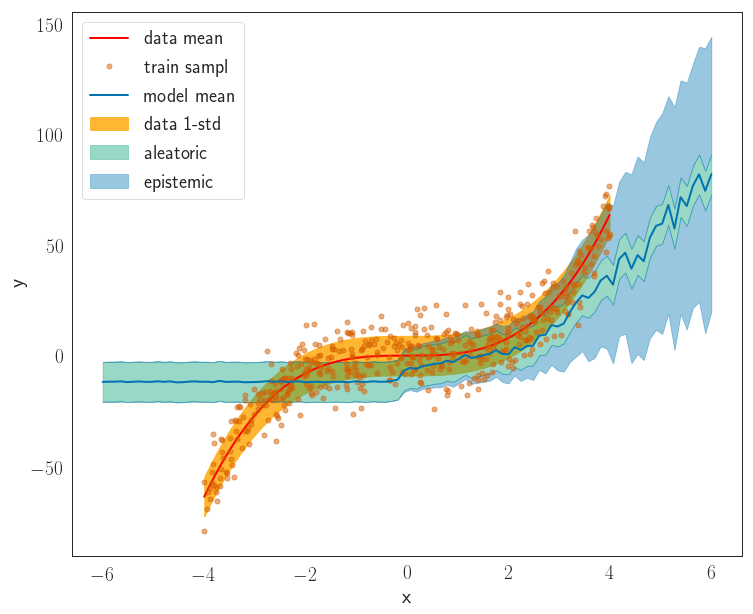

In [777]:
out = Dropout.prediction((x_domain - x_mean)/x_std, train=False)
out = torch.stack(out).cpu().data.numpy()
out = out*y_std.numpy() + y_mean.numpy()

plot_1d_results((data_2.train_set.train_data.numpy(), data_2.train_set.train_labels.numpy()),
                 {'mean':base_model, 'std':noise_model}, (x_domain.numpy(), out, 1/model_params['noise_prec']),
                 method = 'mcdropout')

# filename = 'ex2_mcdropout.pdf'
# fig.savefig( 'images/toy-example'+ filename, bbox_inches='tight', dpi=200)

In [778]:
Vadam = ExperimentVadamMLPReg(dataset,
                        model_params,
                        train_params,
                        optim_params,
                        data_params=data_params,
                        evals_per_epoch=1,
                        normalize_x=True,
                        normalize_y=True,
                        use_cuda=torch.cuda.is_available(),
                        print_freq=1000
    )
Vadam.run()

Epoch [1/1000], Neg. Ave. ELBO: 6.1031, Logloss: 5.3597, Test Logloss: 5.3883 Eval time: 0.000Batch time: 0.018 (0.018) Data time: 0.003 (0.003) 
toydata1d train time 116.520 (116.520)	


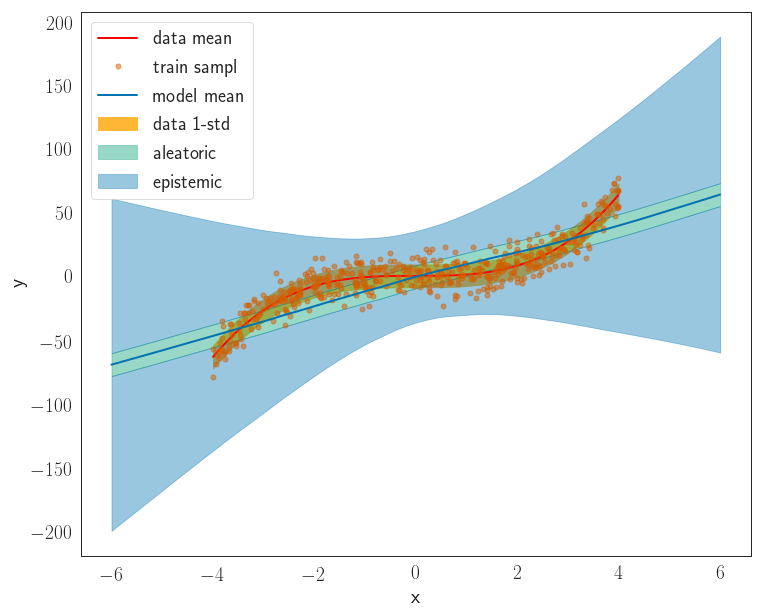

In [800]:
out = Vadam.prediction((x_domain - x_mean)/x_std, train=False)
out = torch.stack(out).cpu().data.numpy()
out = out*y_std.numpy() + y_mean.numpy()

plot_1d_results((data_2.train_set.train_data.numpy(), data_2.train_set.train_labels.numpy()),
                 {'mean':base_model, 'std':noise_model}, (x_domain.numpy(), out, 1/model_params['noise_prec']),
                 method = 'vadam')

# filename = 'ex2_vadam.pdf'
# fig.savefig( 'images/toy-example'+ filename, bbox_inches='tight', dpi=200)

In [797]:
train_params.update({'num_epochs': 40})

PBP = ExperimentPBPReg(dataset,
                        model_params,
                        train_params,
                        data_params,
                        experiment_prefix='toydata',
                        normalize_x=True,
                        normalize_y=True,
                        use_cuda=torch.cuda.is_available(),
                        print_freq=1000
    )
PBP.run()

Epoch [1/40], Train RMSE: 11.0677, Test RMSE: 11.0007, Logloss: -3.8925, Test Logloss: -3.9064 Eval time: 0.053Batch time: 0.000 (0.000) Data time: 0.000 (0.000) 
toydata1d train time 11.668 (11.668)	


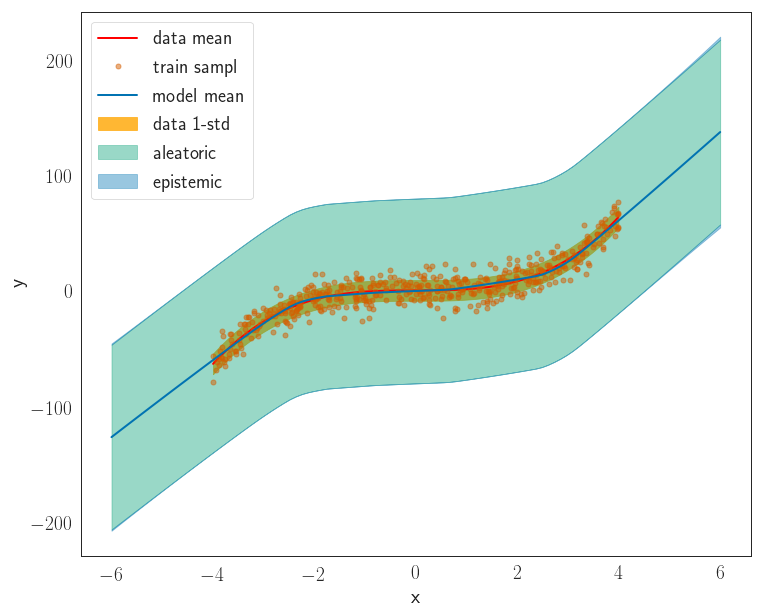

In [798]:
m, v, v_noise = PBP.model.predict(((x_domain - x_mean)/x_std).numpy())

plot_1d_results((data_2.train_set.train_data.numpy(), data_2.train_set.train_labels.numpy()),
                 {'mean':base_model, 'std':noise_model}, (x_domain.numpy(), (m, v), v_noise),
                 method = 'pbp')
# plt.ylim([-70,70])

# filename = 'ex2_pbp.pdf'
# fig.savefig( 'images/toy-example'+ filename, bbox_inches='tight', dpi=200)

# Toy set #3

https://arxiv.org/pdf/1505.05424.pdf

 $$y=x+ 0.3 sin(2π(x+\epsilon)) + 0.3 sin(4π(x+\epsilon)) + \epsilon,  where \epsilon ∼ N(0,0.02) $$